In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential # type: ignore
from tensorflow.keras.layers import Dense, LSTM, Dropout # type: ignore

In [20]:
data = pd.read_csv("NSE-TATAGLOBAL11.csv")
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)


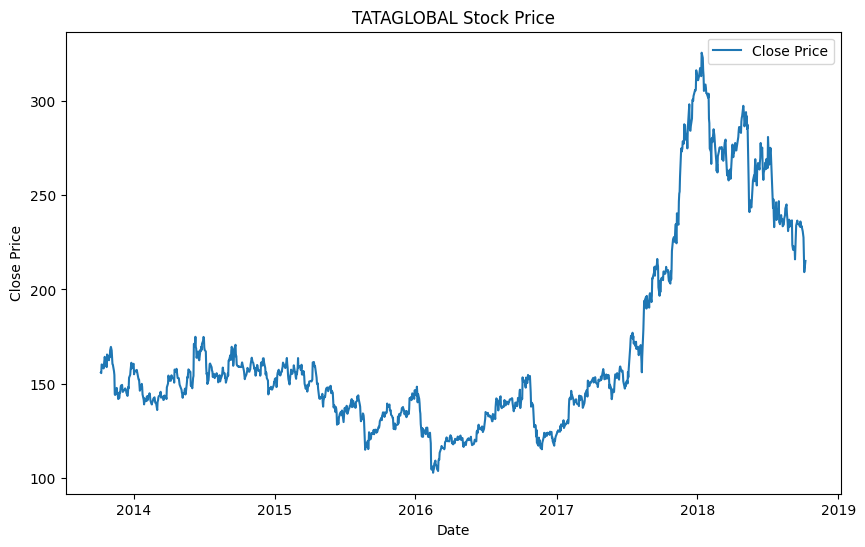

In [21]:
plt.figure(figsize=(10, 6))
plt.plot(data['Close'], label='Close Price')
plt.title('TATAGLOBAL Stock Price')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

In [37]:
data['SMA_50'] = data['Close'].rolling(window=50).mean()
data['SMA_200'] = data['Close'].rolling(window=200).mean()
data['EMA_20'] = data['Close'].ewm(span=20, adjust=False).mean()
data['RSI'] = 100 - (100 / (1 + data['Close'].pct_change().apply(lambda x: max(x, 0)).rolling(window=14).mean() /
                                  data['Close'].pct_change().apply(lambda x: abs(min(x, 0))).rolling(window=14).mean()))
data['Volatility'] = data['Close'].rolling(window=14).std()
data = data.dropna()


In [38]:
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data[['Close', 'SMA_50', 'SMA_200', 'EMA_20', 'RSI', 'Volatility']])
data_scaled = pd.DataFrame(data_scaled, columns=['Close', 'SMA_50', 'SMA_200', 'EMA_20', 'RSI', 'Volatility'], index=data.index)

X = data_scaled[['SMA_50', 'SMA_200', 'EMA_20', 'RSI', 'Volatility']]
y = data_scaled['Close']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [39]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)
lr_rmse = np.sqrt(mean_squared_error(y_test, y_pred_lr))
print(f"Linear Regression RMSE: {lr_rmse}")

Linear Regression RMSE: 0.039216384903451085


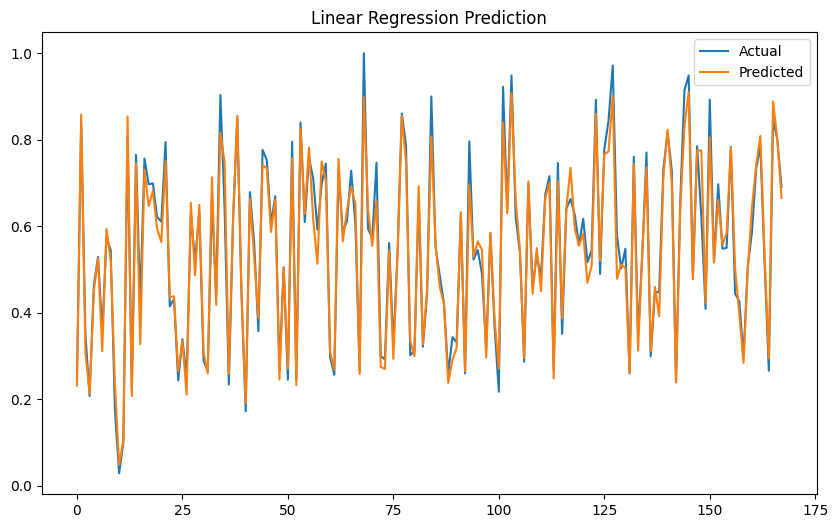

In [40]:
plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label='Actual')
plt.plot(y_pred_lr, label='Predicted')
plt.title('Linear Regression Prediction')
plt.legend()
plt.show()


In [27]:
knn_model = KNeighborsRegressor(n_neighbors=5)
knn_model.fit(X_train, y_train)
y_pred_knn = knn_model.predict(X_test)
knn_rmse = np.sqrt(mean_squared_error(y_test, y_pred_knn))
print(f"KNN RMSE: {knn_rmse}")


KNN RMSE: 0.019574070810261655


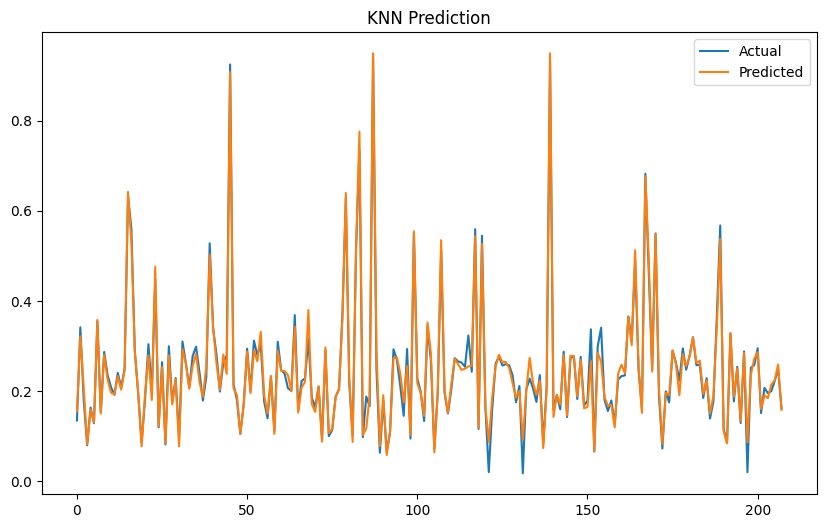

In [28]:
plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label='Actual')
plt.plot(y_pred_knn, label='Predicted')
plt.title('KNN Prediction')
plt.legend()
plt.show()


In [41]:
sequence_length = 60
def create_sequences(data, sequence_length):
    X, y = [], []
    for i in range(sequence_length, len(data)):
        X.append(data[i-sequence_length:i])
        y.append(data[i])
    return np.array(X), np.array(y)

lstm_data = data_scaled['Close'].values
X_lstm, y_lstm = create_sequences(lstm_data, sequence_length)
X_train_lstm, X_test_lstm, y_train_lstm, y_test_lstm = train_test_split(X_lstm, y_lstm, test_size=0.2, random_state=42)


In [42]:
lstm_model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train_lstm.shape[1], 1)),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(1)
])
lstm_model.compile(optimizer='adam', loss='mean_squared_error')


c:\Users\Akash Deep\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [48]:
lstm_model.fit(X_train_lstm, y_train_lstm, epochs=50, batch_size=64)


Epoch 1/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0065
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0062
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0066
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0058
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0058
Epoch 6/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0054
Epoch 7/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0056
Epoch 8/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0061
Epoch 9/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0060
Epoch 10/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0061
Epoch 11/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0051
Epoch 12/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0050
Epoch 13/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0053
Epoch 14/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0057
Epoch 15/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0059
Epoc

In [49]:
y_pred_lstm = lstm_model.predict(X_test_lstm)
lstm_rmse = np.sqrt(mean_squared_error(y_test_lstm, y_pred_lstm))
print(f"LSTM RMSE: {lstm_rmse}")



5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
LSTM RMSE: 0.04922922521671048


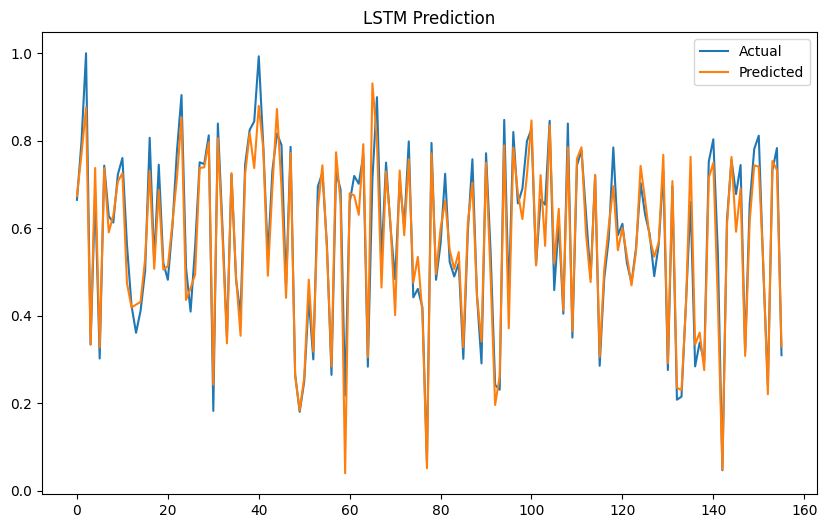

In [50]:
plt.figure(figsize=(10, 6))
plt.plot(y_test_lstm, label='Actual')
plt.plot(y_pred_lstm, label='Predicted')
plt.title('LSTM Prediction')
plt.legend()
plt.show()


In [51]:
models = ['Linear Regression', 'KNN', 'LSTM']
rmse_values = [lr_rmse, knn_rmse, lstm_rmse]

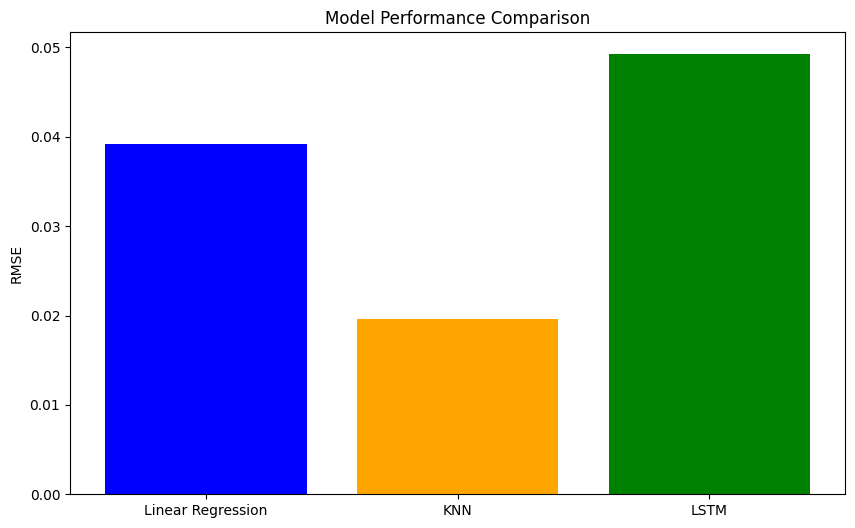

In [52]:
plt.figure(figsize=(10, 6))
plt.bar(models, rmse_values, color=['blue', 'orange', 'green'])
plt.title('Model Performance Comparison')
plt.ylabel('RMSE')
plt.show()

